# **Introduction**

In this project I want to explore how videogames can serve as a source for synthetic data in computer vision use cases. For a proof of concept, I chose the game Mario Kart Super Circuit. After I recorded images from the game, a Convolutional Neural Network will be trained to classify the images into three different classes which correspond to a steering-direction the driver should take, based on the street ahead:

1. Left
2. Right
3. Forward

# **Task 1 - The Data**

The data was collected by myself. To do so, I used the imageCollector.py script, which can also be found in this project. The script simply records an image once every 0.25 seconds and saves the file. The filename includes the direction according to which button was pressed at the time the image was taken. If no direction-key (right, left) was used, the direction is "forward". By recording the data this way, I was able to not only record the images, but at the same time also the labels belonging to the images. However, I must mention that this method can result in some mistakes, depending on how "correctly" I steered the kart in the game. I chose to use this method anyway, because it represented an efficient way to save time while the data collection phase.

## I. What exactly is the data?

The dataset consists of images taken from the videogame. Within Python and the following experiments, the images will be represented by Tensors, which are multi-dimensional arrays. While the exact size of the images does not matter at this point, I want to mention that each image is divided into three different "layers" - one for each RGB-channel. 

## II. Why this data?

The collected data is perfect for this project and the PoC of my proposed idea, because it is rather simple. The videogame itself is quite old and was originally released for very limited hardware, therefore the graphics are of a low-resolution and dont include many details. Furthermore, I recorded only the lower half of the games screen, as this is where the road can be found. I expect that these two points will not only make it more simple for a CNN to learn to classify the images correctly, but that the process will also be quite fast. 

# **Task 2 - Initial Data Analysis**

First of all, I want to present an example image. After that, we will take a look at the distribution of classes.

In [1]:
import pandas as pd
import os
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision.io import read_image
from torch.utils.tensorboard import SummaryWriter
import copy
import time
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

1094    2
Name: label, dtype: int64


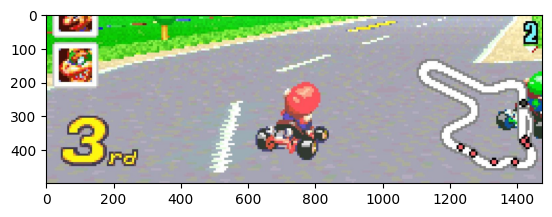

In [7]:
# show an image using PIL
img = cv.imread("data/train/20241109_174104_492494_right.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # convert colorspace to RGB
plt.imshow(img)
train_labels = pd.read_csv("train_labels.csv")
label = train_labels[train_labels["filename"] == "20241109_174104_492494_right.jpg"]["label"]
print(label)

The label belonging to the image is "2", which is the encription for "right". 

Next, we can inspect the size of the images.

In [14]:
print(f"The image is of shape {img.shape}")

The image is of shape (500, 1475, 3)


The images are 500 pixels high and 1475 pixels high. This unusual format originates from the limitations I described in the introduction where I used only the lower-half of the games screen. Furthermore we can see here the three RGB-layers, which I talked about in the previous task.

Now lets take a look at the distribution of the classes.

**DISCLAIMER:** I deleted some images randomly before from classes with more images than others, so that each class has rougly the same amount of images.

In [11]:
left = 0
right = 0
forward = 0

for file in os.listdir("data/train"):
    
    direction = file.split("_")[3].split(".")[0]

    if direction == "left":
        left += 1
    elif direction == "right":
        right += 1
    elif direction == "forward":
        forward += 1

for file in os.listdir("data/test"):
    
    direction = file.split("_")[3].split(".")[0]

    if direction == "left":
        left += 1
    elif direction == "right":
        right += 1
    elif direction == "forward":
        forward += 1

print("Left: ", left)
print("Right: ", right)
print("Forward: ", forward)
print(f"Total: {left + right + forward}")

Left:  525
Right:  532
Forward:  524
Total: 1581


We can see that all classes have approximately the same amount of images, around 525-530. This sums up to a total size of the dataset of 1581 images.

# Load ResNet50 model

In [4]:
torch.cuda.set_device(0)

In [16]:
weights = models.ResNet50_Weights.DEFAULT
preprocess_transform = weights.transforms()
model = models.resnet50(weights=weights)

# Move model to gpu if available
if torch.cuda.is_available():
    model.cuda()

# Load Images in Dataset and DataLoaders

## I. Define Custom Dataset Class

In [17]:
# code is from torch documentation
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Ensure proper indexing by using .loc[idx] or .iloc[idx]
        # Assuming first column is image filename and second column is label
        img_name = self.img_labels.iloc[idx, 0]  # Get filename from first column
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]  # Get label from second column

        if self.transform:
            image = self.transform(image)

        return image, label

## II: Load Datasets and create DataLoaders

In [18]:
train_dataset = CustomImageDataset(annotations_file="train_labels.csv", img_dir="data/train", transform=preprocess_transform)
test_dataset = CustomImageDataset(annotations_file="test_labels.csv", img_dir="data/test", transform=preprocess_transform)

# train dataset will be divided into validation and train
valid_dataset = CustomImageDataset(annotations_file="train_labels.csv", img_dir="data/train", transform=preprocess_transform)

In [19]:
# Following Code is from lecture notebook 06_01_lenet5
BATCH_SIZE = 64
NUM_WORKERS = 4
VALIDATION_RATIO = 0.1
TRAIN_SIZE = 1264

num = int(VALIDATION_RATIO * TRAIN_SIZE)
train_indices = torch.arange(0, TRAIN_SIZE - num)
valid_indices = torch.arange(TRAIN_SIZE - num, TRAIN_SIZE)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=False,
                          sampler=valid_sampler)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          # Drop the last (usually smaller) batch. 
                          # Since we shuffle the dataset every time we load it 
                          # (using the SubsetRandomSampler) -- and thus every epoch --
                          # we randomly exclude a small subset of the data in every epoch.
                          # Otherwise, the last batch would contain fewer items and thus 
                          # these items would have a disproportionally high impact 
                          # on weight update during training
                          drop_last=True,
                          sampler=train_sampler)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         shuffle=False)

## III. Check Dataset

Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
Class labels of 10 examples: tensor([1, 2, 0, 2, 1, 1, 0, 1, 0, 2])
---------
tensor([1, 2, 0, 2, 1, 1, 0, 1, 0, 2])


<Figure size 640x480 with 0 Axes>

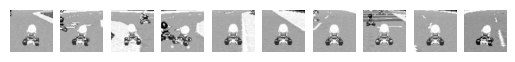

In [20]:
# Checking the dataset
torch.manual_seed(42) # set random seed as the train loader always loads a new permutation of the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    print('---------')
    print(labels[0:10])
    plt.figure()
    fig, axs = plt.subplots(1, 10) 
    for i in range(0,10):
        axs[i].imshow(images[i,0], cmap="gray")
        axs[i].set_axis_off()
    break

# Training

In [21]:
def get_targets_and_predictions(model, data_loader):
    '''
    create two lists: actual and predicted target 
    of a dataset in a data_loader
    enumerated in batches
    Assumption: model returns a tensor with dimensionality (batch, class probability)
    '''
    all_targets, all_predictions = [], []
    
    for i, (features, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            features, targets = features.to("cuda"), targets.to("cuda")
        
        # Predict probabilities for each instance in the current batch
        y_proba = model(features)
        _, predicted_labels = torch.max(y_proba, dim=1)
        
        # Append the batch predictions and targets to the lists
        all_targets.append(targets)
        all_predictions.append(predicted_labels)
    
    # Concatenate the list of tensors into a single tensor
    all_targets = torch.cat(all_targets)
    all_predictions = torch.cat(all_predictions)
    
    # Move tensors to CPU and convert to numpy arrays
    if torch.cuda.is_available():
        all_targets = all_targets.cpu()
        all_predictions = all_predictions.cpu()
        
    all_targets = all_targets.numpy()
    all_predictions = all_predictions.numpy()
    
    return all_targets, all_predictions

In [22]:
def train_model(model, num_epochs, 
                train_loader, valid_loader,
                optimizer, criterion):

    writer = SummaryWriter()
    best_model_state=copy.deepcopy(model.state_dict())
    best_valid_acc=-float('inf')
    best_epoch=0

    start_time = time.time()

    model.to("cuda")
    
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            # Check if gpu available
            if torch.cuda.is_available():
                # Move features and targets to the correct device
                features, targets = features.to("cuda"), targets.to("cuda")

            y_pred = model(features)

            loss = criterion(y_pred, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():  
            y, y_pred=get_targets_and_predictions(model=model, data_loader=train_loader)
            train_acc=accuracy_score(y, y_pred)*100

            y, y_pred=get_targets_and_predictions(model=model, data_loader=valid_loader)
            valid_acc=accuracy_score(y, y_pred)*100
                        
            print(f'Epoch: {epoch} | Train: {train_acc :.2f}% | Validation: {valid_acc :.2f}%')

            writer.add_scalars("lenet/acc", {'train': train_acc, 'val': valid_acc}, epoch)
            writer.flush()
            
            if (valid_acc>best_valid_acc):
                best_valid_acc=valid_acc
                best_epoch=epoch
                best_model_state=copy.deepcopy(model.state_dict())

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')
        
    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')
    writer.close()
    print("Best Validation Epoch: ", best_epoch)
    model.load_state_dict(best_model_state)
    return model

## I. Replace final layer to match new labels

In [23]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
# Replace the final layer for the number of classes in your dataset
num_classes = 3  # Change this to the number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [25]:
torch.manual_seed(42)

criterion=torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

NUM_EPOCHS = 10

model = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    criterion=criterion)

Epoch: 0 | Train: 73.35% | Validation: 70.63%
Time elapsed: 0.52 min
Epoch: 1 | Train: 84.28% | Validation: 83.33%
Time elapsed: 1.05 min
Epoch: 2 | Train: 80.15% | Validation: 75.40%
Time elapsed: 1.57 min
Epoch: 3 | Train: 83.82% | Validation: 76.98%
Time elapsed: 2.09 min
Epoch: 4 | Train: 82.26% | Validation: 71.43%
Time elapsed: 2.61 min
Epoch: 5 | Train: 99.91% | Validation: 82.54%
Time elapsed: 3.13 min
Epoch: 6 | Train: 100.00% | Validation: 82.54%
Time elapsed: 3.65 min
Epoch: 7 | Train: 100.00% | Validation: 80.95%
Time elapsed: 4.18 min
Epoch: 8 | Train: 100.00% | Validation: 84.13%
Time elapsed: 4.70 min
Epoch: 9 | Train: 100.00% | Validation: 84.13%
Time elapsed: 5.22 min
Total Training Time: 5.22 min
Best Validation Epoch:  8


In [26]:
y, y_pred=get_targets_and_predictions(model=model, data_loader=test_loader)
test_acc=accuracy_score(y, y_pred)*100
print(f'Test accuracy {test_acc :.2f}%')

Test accuracy 80.44%


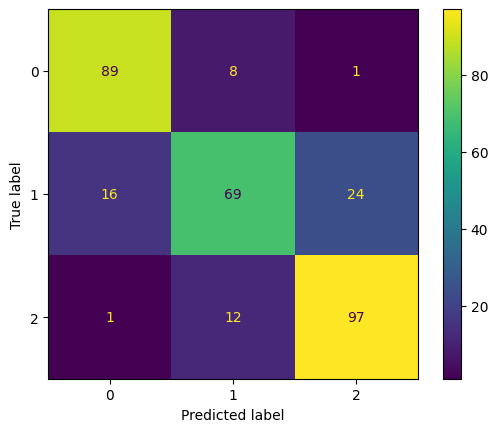

In [27]:
y, y_pred=get_targets_and_predictions(model=model, data_loader=test_loader)
ConfusionMatrixDisplay.from_predictions(y, y_pred)

# Save the model

In [30]:
torch.save(model, "fine_tuned_resnet50.pth")

# Load the model

In [34]:
model = torch.load("fine_tuned_resnet50.pth")
model = model.to("cuda")

# If using state
# Initialize the model (same architecture as before)
#model = models.resnet50(weights=None)  # set weights=None to avoid loading pretrained weights
# Load the saved state dictionary
#model.load_state_dict(torch.load("fine_tuned_model.pth"))
# Move to the correct device if needed
#model = model.to(device)


/tmp/ipykernel_1560/1108327072.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("fine_tuned_resnet50.pth")
